In this notebook, we run some experiments on simulated data of **Hitting Time Prediction**.

In [1]:
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font="STIXGeneral", context="talk", palette="colorblind")

import warnings
warnings.filterwarnings('ignore')

## Data generation & preprocessing

***Generate longitudinal markers***

R callback write-console: Loading required package: nlme
  
R callback write-console: Loading required package: survival
  
R callback write-console: Loading required package: doParallel
  
R callback write-console: Loading required package: foreach
  
R callback write-console: Loading required package: iterators
  
R callback write-console: Loading required package: parallel
  
R callback write-console: Loading required package: rstan
  
R callback write-console: Loading required package: StanHeaders
  
R callback write-console: 
rstan version 2.32.7 (Stan version 2.32.2)

  
R callback write-console: For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)
For within-chain threading using `reduce_sum()` or `map_rect()` Stan functions,
change `threads_per_chain` option:
rstan_options(threads_per_chain = 1)

  


Index(['id', 'years', 'status', 'drug', 'age', 'sex', 'year', 'ascites',
       'hepatomegaly', 'spiders', 'edema', 'serBilir', 'serChol', 'albumin',
       'alkaline', 'SGOT', 'platelets', 'prothrombin', 'histologic', 'status2',
       'times', 'tte', 'label'],
      dtype='object')


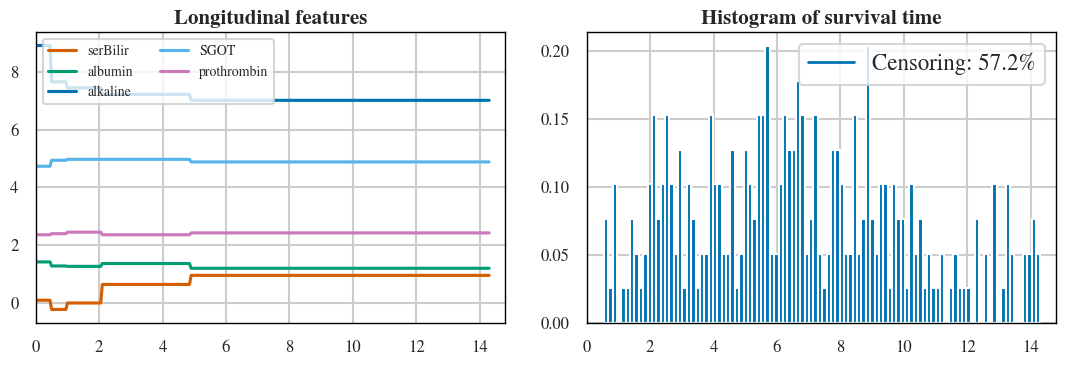

In [2]:
from examples.data.PBC import load_PBC_Seq
paths, surv_labels, longi_feat_list, static_feature, static_feature_list, ddh_info_sup = load_PBC_Seq.load()
n_samples, n_sampling_times, _ = paths.shape
n_longi_feats = paths.shape[-1] - 1
sampling_times = paths[0, :, 0]
surv_times, surv_inds = surv_labels[:, 0], surv_labels[:, 1]

## Dynamic DeepHit

In [3]:
from examples.learner.dynamic_deephit_ext import construct_df, Dynamic_DeepHit_ext

cont_feat, bin_feat, time_scale, bin_df = ddh_info_sup
df = construct_df(paths.clone(), surv_labels, cont_feat, bin_feat, time_scale, bin_df)

dynamic_deephit = Dynamic_DeepHit_ext()
(data, time_, label), (mask1, mask2, mask3), (data_mi) = dynamic_deephit.preprocess(df, cont_feat, bin_feat)
dynamic_deephit.sampling_times = np.array(sampling_times)
dynamic_deephit.ddh_info_sup = ddh_info_sup

In [4]:
# Setup for experiment training
train_test_share = .8
n_samples = data.shape[0]
n_train_samples = int(train_test_share * n_samples)
train_index = np.random.choice(n_samples, n_train_samples, replace=False)
test_index = [i for i in np.arange(n_samples) if i not in train_index]

BURN-IN TRAINING ...
itr: 0010 | burn-in loss: 149.5505
itr: 0020 | burn-in loss: 131.7895
itr: 0030 | burn-in loss: 95.6961
itr: 0040 | burn-in loss: 121.4685
itr: 0050 | burn-in loss: 90.2972
MAIN TRAINING ...
itr: 0010 | loss: 101.3380
itr: 0020 | loss: 101.6380
itr: 0030 | loss: 97.2594
itr: 0040 | loss: 94.9317
itr: 0050 | loss: 73.5437
itr: 0060 | loss: 70.0171
itr: 0070 | loss: 50.4061
itr: 0080 | loss: 48.5254
itr: 0090 | loss: 46.1495
itr: 0100 | loss: 41.6508
itr: 0110 | loss: 36.3357
itr: 0120 | loss: 34.1549
itr: 0130 | loss: 24.9374
itr: 0140 | loss: 25.2749
itr: 0150 | loss: 25.1522
itr: 0160 | loss: 24.1792
itr: 0170 | loss: 21.9663
itr: 0180 | loss: 15.4342
itr: 0190 | loss: 16.7289
itr: 0200 | loss: 18.0606
itr: 0210 | loss: 16.1059
itr: 0220 | loss: 17.2010
itr: 0230 | loss: 17.5144
itr: 0240 | loss: 18.4931
itr: 0250 | loss: 20.6991


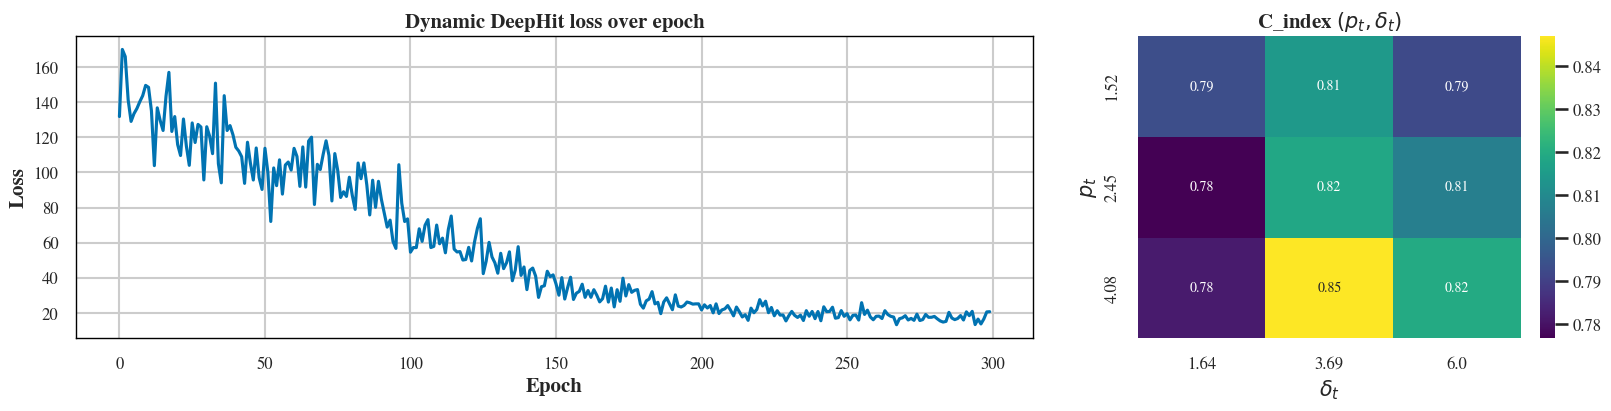

In [5]:
# split data
tr_data, te_data = data[train_index, :, :], data[test_index, :, :]
tr_data_mi, te_data_mi = data_mi[train_index, :, :], data_mi[test_index, :, :]
tr_time,te_time = time_[train_index, :], time_[test_index, :]
tr_label,te_label = label[train_index, :], label[test_index, :]
tr_mask1,te_mask1 = mask1[train_index, :, :], mask1[test_index, :, :]
tr_mask2,te_mask2 = mask2[train_index, :, :], mask2[test_index, :, :]
tr_mask3,te_mask3 = mask3[train_index, :], mask3[test_index, :]

tr_data_full = (tr_data, tr_data_mi, tr_label, tr_time, tr_mask1, tr_mask2, tr_mask3)

fig = plt.figure(layout="constrained", figsize=(16, 4))
axs = fig.subplot_mosaic(
    """
    AAAAABB
    """,
    gridspec_kw={
        "wspace": 0.2,
        "hspace": 0.5,
    },
)
for ax in axs.values():
    for spine in ax.spines.values():
        spine.set_linewidth(1)
        spine.set_edgecolor("black")
# train
dynamic_deephit.train(tr_data_full, is_trained=False, ax=axs["A"], ckpt_dir="./dynamic_deephit_ckpt/PBC")


# performance evaluation
from examples.learner.utils import score
sampling_times = np.array(paths[0, :, 0])
tte = surv_labels[surv_labels[:, 1] == 1][:, 0]
quantile_pred_times = np.array([.1, .25, .5])
pred_times = np.quantile(np.array(tte), quantile_pred_times)
n_eval_times = 3
eval_times = []
for k in range(n_eval_times):
    eval_times.append(max(np.quantile(np.array(tte), quantile_pred_times + (k+1) * .15) - pred_times))
eval_times = np.array(eval_times)
# predict
pred_time_scale = (pred_times * time_scale).astype(int)
eval_time_scale = (eval_times * time_scale).astype(int)
ddh_surv_preds = dynamic_deephit.predict(te_data, te_data_mi, 
                                         pred_time_scale, eval_time_scale)

n_pred_times = len(pred_times)
n_eval_times = len(eval_times)
ddh_cindex = np.zeros((n_pred_times, n_eval_times))
for j in np.arange(n_pred_times):
    pred_time = pred_times[j]
    
    # remove individuals whose survival time less than prediction time
    surv_times_test = te_time.flatten()
    surv_inds_test = te_label.flatten()
    idx_sel = surv_times_test >= pred_time
    surv_times_ = surv_times_test[idx_sel] - pred_time
    surv_inds_ = surv_inds_test[idx_sel]
    surv_labels_ = np.array([surv_times_, surv_inds_]).T
    surv_preds_ = ddh_surv_preds[:, j][idx_sel]

    ddh_cindex[j] = score("c_index", surv_labels_, surv_labels_, 
                          surv_preds_, eval_time_scale)

sns.heatmap(ddh_cindex, annot=True, annot_kws={"size": 10}, cmap="viridis", ax=axs["B"])
axs["B"].set_xticklabels([str(round(x, 2)) for x in eval_times])
axs["B"].set_yticklabels([str(round(x, 2)) for x in pred_times])
axs["B"].tick_params(axis='y', labelsize=12)
axs["B"].tick_params(axis='x', labelsize=12)
axs["B"].set_xlabel("$\delta_t$", fontweight="semibold", fontsize=15)
axs["B"].set_ylabel("$p_t$", fontweight="semibold", fontsize=15)
axs["B"].set_title("C_index $(p_t, \delta_t)$", fontweight="semibold", fontsize=15)
axs["B"].collections[0].colorbar.ax.tick_params(labelsize=12)
axs["B"].legend().remove()
plt.show()

## Explaination

In [6]:
from src.survinsights.longi_explainer import explainer
from src.survinsights.local_explaination._survlongishap import survshap_longi

quantile_pred_times = np.array([.25, .5])
tte = surv_labels[surv_labels[:, 1] == 1][:, 0]
pred_times = np.quantile(np.array(tte), quantile_pred_times)
dt = sampling_times[1] - sampling_times[0]
all_shap = []
for pred_time in pred_times:
    sel_paths = paths[surv_labels[:, 0] > pred_time + 10 * dt]
    sel_static_feature = static_feature[surv_labels[:, 0] > pred_time + 10 * dt]
    sel_surv_labels = surv_labels[surv_labels[:, 0] > pred_time + 10 * dt]
    model_explainer = explainer(dynamic_deephit, "DDH", sel_paths, sel_surv_labels, sel_static_feature)
    seed = 0
    shap_res = []
    K = min(10, int(.75 * sel_paths.shape[0]))
    for i in range(K):
        tmp = survshap_longi(model_explainer, i, sel_paths[i], sel_static_feature[i], np.array([pred_time]), 
                            prediction_type="med-survival", seed=seed, n_split=4, intercept=True)

        seed += 1
        shap_res.append(tmp)

    all_shap.append(shap_res)

[0.01123892 0.43284202 0.         0.         0.55591906 0.
 0.        ]


100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


[0.54404972 0.         0.00206895 0.07240068 0.35083816 0.03064248
 0.        ]


100%|██████████| 1/1 [00:03<00:00,  3.24s/it]


[0.81772675 0.         0.         0.01489473 0.16737852 0.
 0.        ]


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


[0.86315654 0.11029595 0.         0.         0.02654751 0.
 0.        ]


100%|██████████| 1/1 [00:01<00:00,  1.96s/it]


[0.         0.21157811 0.         0.         0.78842189 0.
 0.        ]


100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


[0.876256   0.11346319 0.         0.         0.01028081 0.
 0.        ]


100%|██████████| 1/1 [00:02<00:00,  2.03s/it]


[0.75337341 0.01025051 0.         0.03531261 0.20106347 0.
 0.        ]


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


[0.22259853 0.00977479 0.         0.11718605 0.65044063 0.
 0.        ]


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


[0.82874006 0.11711949 0.         0.         0.         0.05414045
 0.        ]


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


[0.77948343 0.14217671 0.         0.         0.07833986 0.
 0.        ]


100%|██████████| 1/1 [00:01<00:00,  1.50s/it]


[0.         0.34550573 0.         0.         0.65449427 0.
 0.        ]


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


[5.20605667e-01 0.00000000e+00 5.72616582e-02 3.74423503e-02
 3.84306200e-01 3.84124039e-04 0.00000000e+00]


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


[0.83426989 0.0458639  0.09798374 0.01804689 0.         0.
 0.00383557]


100%|██████████| 1/1 [00:02<00:00,  2.34s/it]


[0.         0.11869397 0.         0.         0.88130603 0.
 0.        ]


100%|██████████| 1/1 [00:02<00:00,  2.38s/it]


[0.92289626 0.06346561 0.         0.         0.01363813 0.
 0.        ]


100%|██████████| 1/1 [00:02<00:00,  2.41s/it]


[0.77648567 0.         0.         0.02872858 0.19478574 0.
 0.        ]


100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


[1.34467021e-01 2.69823161e-02 3.10176777e-05 1.17539944e-01
 7.20979701e-01 0.00000000e+00 0.00000000e+00]


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


[0.94779385 0.04689504 0.         0.         0.00531111 0.
 0.        ]


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


[0.87118799 0.07984325 0.02642235 0.00168188 0.02086453 0.
 0.        ]


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


[0.86020366 0.0675196  0.04122275 0.00516061 0.02589338 0.
 0.        ]


100%|██████████| 1/1 [00:01<00:00,  1.67s/it]


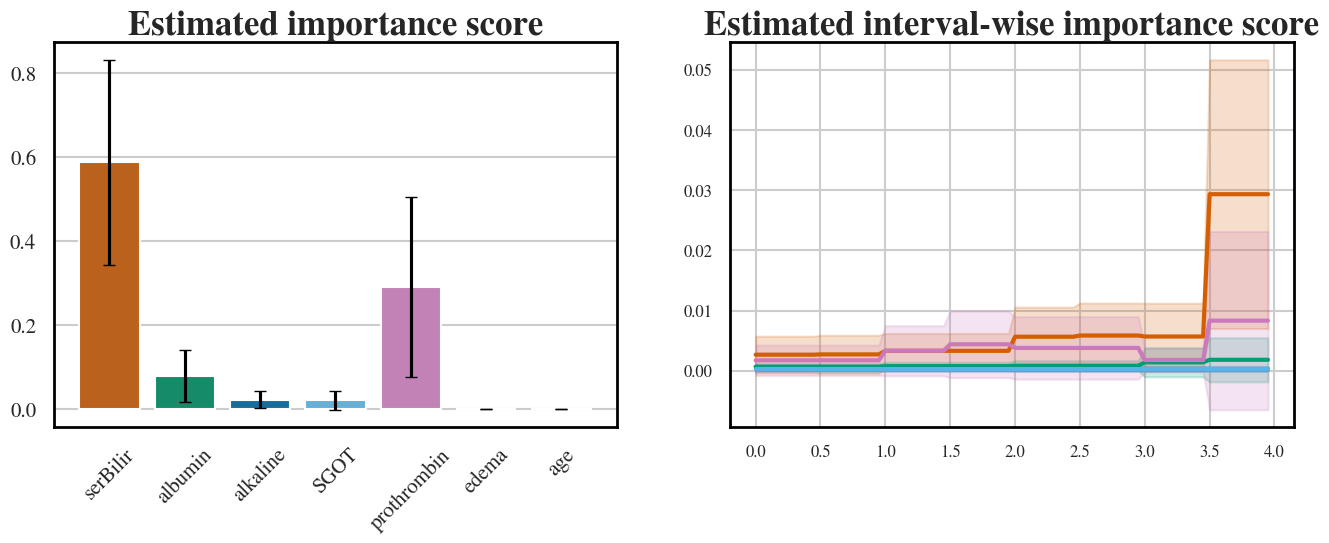

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16,5))

for ax in fig.axes:
    [x.set_linewidth(2) for x in ax.spines.values()]
    [x.set_edgecolor('black') for x in ax.spines.values()]

colors = ["r", "g", "b", "c", "m", "#E69F00", "#5E3C99", "#ff9896"]
x_labels = longi_feat_list + static_feature_list

idx_pred_t = 1
pred_time = pred_times[idx_pred_t]
n_merged_time = 5
pred_time_idx = (int((pred_time  / (sampling_times[1] - sampling_times[0]))) // n_merged_time) * n_merged_time

##################  ESTIMATION   ########################
shap_at_pt = []
all_shap = np.array(all_shap)
n_expl_samples = all_shap.shape[1]
for i in range(n_expl_samples):
    a, b = np.asarray(all_shap[idx_pred_t][i][0], dtype=float), np.asarray(all_shap[idx_pred_t][i][1], dtype=float)
    tmp = np.divide(a, b, out=np.full_like(a, np.nan, dtype=float), where=b!=0)
    # shap_at_pt.append(tmp)
    if len(np.unique(tmp)) > 2:
        shap_at_pt.append(tmp)
mean_shap_at_pt = np.nanmean(np.array(shap_at_pt), axis=0)
std_shap_at_pt = np.nanstd(np.array(shap_at_pt), axis=0)
shap_per_feat = np.nansum(mean_shap_at_pt, axis=1)
ci_shap_at_pt = 1.96 * np.std(np.nansum(np.array(shap_at_pt), axis=-1), axis=0, ddof=1) / np.sqrt(len(shap_at_pt))
est_score_df = pd.DataFrame(np.array([x_labels, shap_per_feat.tolist()]).T, columns = ["feat", "value"])
est_score_df["value"] = est_score_df["value"].astype(float)
sns.barplot(data=est_score_df, x="feat", y="value", ax=axs[0], palette=colors)
axs[0].errorbar(
    x=np.arange(ci_shap_at_pt.shape[0]),
    y=shap_per_feat,
    yerr=ci_shap_at_pt,
    fmt='none',
    c='black',
    capsize=4
)
axs[0].tick_params(axis='x', labelsize=15, labelrotation=45) 
axs[0].tick_params(axis='y', labelsize=15)
axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[0].set_title("Estimated importance score", fontweight="semibold", fontsize=25)

for l in range(n_longi_feats):
    axs[1].plot(sampling_times, mean_shap_at_pt[l], label='$X_'+ str(l+1) + '$', linewidth=3, color=colors[l])
    axs[1].fill_between(sampling_times, mean_shap_at_pt[l] - std_shap_at_pt[l], mean_shap_at_pt[l] + std_shap_at_pt[l], color=colors[l], alpha=0.2)
axs[1].set_title("Estimated interval-wise importance score", fontweight="semibold", fontsize=25)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)
plt.show()